# PCPCA Implementation from: https://arxiv.org/abs/2012.07977

In [1]:
import numpy as np
from scipy.linalg import sqrtm
import pandas as pd
from scipy.stats import multivariate_normal
inv = np.linalg.inv
slogdet = np.linalg.slogdet
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

In [2]:
class PCPCA:

    def __init__(self, n_components=2, gamma=0.5):
        """Initialize PCPCA model.
        """
        self.k = n_components
        self.gamma = gamma

    def fit(self, X, Y):
        """Fit model via maximum likelihood estimation.
        """
        assert X.shape[0] == Y.shape[0]  # Should have same number of features
        p, n, m = X.shape[0], X.shape[1], Y.shape[1]

        # Get sample covariance
        Cx, Cy = self._compute_sample_covariance(
            X), self._compute_sample_covariance(Y)

        # Differential covariance
        Cdiff = n * Cx - self.gamma * m * Cy

        # Eigendecomposition
        eigvals, U = np.linalg.eigh(Cdiff)

        # Sort by eigenvalues and truncate to number of components
        sorted_idx = np.argsort(-eigvals)
        eigvals = eigvals[sorted_idx]
        U = U[:, sorted_idx]
        Lambda = np.diag(eigvals)
        Lambda, U = Lambda[:self.k, :self.k], U[:, :self.k]

        # MLE for sigma2
        sigma2_mle = 1 / (p - self.k) * \
            np.sum(eigvals[self.k:] / (n - self.gamma * m))

        # MLE for W
        Lambda_scaled = Lambda / (n - self.gamma * m)
        W_mle = U @ sqrtm(Lambda_scaled - sigma2_mle * np.eye(self.k))

        self.sigma2_mle = sigma2_mle
        self.W_mle = W_mle

    def transform(self, X, Y):
        """Embed data using fitted model.
        """
        
        t = self.W_mle.T @ X, self.W_mle.T @ Y
        return t

    def fit_transform(self, X, Y):
        self.fit(X, Y)
        t = self.transform(X, Y)
        return t

    def sample(self):
        """Sample from the fitted model.
        """
        pass

    def get_gamma_bound(self, X, Y):
        """Compute the upper bound on gamma such that sigma2 > 0.
        """
        p = X.shape[0]
        Cx = self._compute_sample_covariance(X)
        Cy = self._compute_sample_covariance(Y)
        Cx_eigvals = -np.sort(-np.linalg.eigvals(Cx))
        Cy_eigvals = -np.sort(-np.linalg.eigvals(Cy))

        gamma_bound = np.sum(Cx_eigvals[self.k-1:]) / \
            ((p - self.k) * Cy_eigvals[0])
        return gamma_bound

    def _compute_sample_covariance(self, data):
        """Compute sample covariance where data is a p x n matrix.
        """
        n = data.shape[1]
        cov = 1 / n * data @ data.T
        return cov

    # Indication matrix for observed values
    def make_L(self, X):
        p = X.shape[0]
        unobserved_idx = np.where(np.isnan(X))[0]
        observed_idx = np.setdiff1d(np.arange(p), unobserved_idx)
        L = np.zeros((observed_idx.shape[0], p))
        for ii, idx in enumerate(observed_idx):
            L[ii, idx] = 1
        return L

    # Indication matrix for unobserved values
    def make_P(self, X):
        p = X.shape[0]
        unobserved_idx = np.where(np.isnan(X))[0]
        P = np.zeros((unobserved_idx.shape[0], p))
        for ii, idx in enumerate(unobserved_idx):
            P[ii, idx] = 1
        return P

    def impute_missing_data(self, X):
        p, n = X.shape
        W, sigma2 = self.W_mle, self.sigma2_mle

        # Indication matrices for observed values
        Ls = [self.make_L(X[:, ii]) for ii in range(n)]

        # Indication matrices for unobserved values
        Ps = [self.make_P(X[:, ii]) for ii in range(n)]

        # Cov between observed features
        As = [Ls[ii] @ (W @ W.T + sigma2 * np.eye(p)) @ Ls[ii].T for ii in range(n)]

        # Cov between unobserved features
        Cs = [Ps[ii] @ (W @ W.T + sigma2 * np.eye(p)) @ Ps[ii].T for ii in range(n)]

        # Cov between unobserved/observed features
        Fs = [Ps[ii] @ (W @ W.T + sigma2 * np.eye(p)) @ Ls[ii].T for ii in range(n)]

        # Find conditional mean of unobserved values
        X_imputed = X.copy()
        for ii in range(n):
            unobserved_idx = np.where(np.isnan(X[:, ii]))[0]
            observed_idx = np.setdiff1d(np.arange(p), unobserved_idx)
            xhat_u_ii = Fs[ii] @ inv(As[ii]) @ X_imputed[:, ii][observed_idx]
            X_imputed[unobserved_idx, ii] = xhat_u_ii

        return X_imputed


    def gradient_descent_missing_data(self, X, Y, n_iter=500, verbose=True):

        def grads(X, Y, W, sigma2, gamma):
            p, n = X.shape
            m = Y.shape[1]

            # Indication matrices
            Ls = [self.make_L(X[:, ii]) for ii in range(n)]
            Ms = [self.make_L(Y[:, ii]) for ii in range(m)]

            As = [Ls[ii] @ (W @ W.T + sigma2 * np.eye(p)) @ Ls[ii].T for ii in range(n)]
            Bs = [Ms[ii] @ (W @ W.T + sigma2 * np.eye(p)) @ Ms[ii].T for ii in range(m)]

            running_sum_W_X = np.zeros((p, p))
            running_sum_sigma2_X = 0
            for ii in range(n):
                L, A = Ls[ii], As[ii]
                x = L @ np.nan_to_num(X[:, ii], nan=0)
                Di = L.shape[0]
                A_inv = inv(A)

                curr_summand_W = L.T @ A_inv @ (np.eye(Di) - np.outer(x, x) @ A_inv) @ L
                running_sum_W_X += curr_summand_W

                curr_summand_sigma2 = np.trace(A_inv @ L @ L.T) - np.trace(A_inv @ np.outer(x, x) @ A_inv @ L @ L.T)
                running_sum_sigma2_X += curr_summand_sigma2

            running_sum_W_Y = np.zeros((p, p))
            running_sum_sigma2_Y = 0
            for jj in range(m):
                M, B = Ms[jj], Bs[jj]
                y = M @ np.nan_to_num(Y[:, jj], nan=0)
                Ej = M.shape[0]
                B_inv = inv(B)

                curr_summand_W = M.T @ B_inv @ (np.eye(Ej) - np.outer(y, y) @ B_inv) @ M
                running_sum_W_Y += curr_summand_W

                curr_summand_sigma2 = np.trace(B_inv @ M @ M.T) - np.trace(B_inv @ np.outer(y, y) @ B_inv @ M @ M.T)
                running_sum_sigma2_Y += curr_summand_sigma2

            W_grad = -(running_sum_W_X - gamma * running_sum_W_Y) @ W
            sigma2_grad = -0.5 * running_sum_sigma2_X + gamma/2.0 * running_sum_sigma2_Y

            return W_grad, sigma2_grad

        def log_likelihood(X, Y, W, sigma2, gamma):
            p, n = X.shape
            m = Y.shape[1]
            Ls = [self.make_L(X[:, ii]) for ii in range(n)]
            Ms = [self.make_L(Y[:, ii]) for ii in range(m)]

            As = [Ls[ii] @ (W @ W.T + sigma2 * np.eye(p)) @ Ls[ii].T for ii in range(n)]
            Bs = [Ms[ii] @ (W @ W.T + sigma2 * np.eye(p)) @ Ms[ii].T for ii in range(m)]

            running_sum_X = 0
            for ii in range(n):
                L = Ls[ii]
                A = As[ii]
                x = L @ np.nan_to_num(X[:, ii], nan=0)
                Di = L.shape[0]
                A_inv = inv(A)

                curr_summand = Di * np.log(2 * np.pi) + slogdet(A)[1] + np.trace(A_inv @ np.outer(x, x))
                running_sum_X += curr_summand

            running_sum_Y = 0
            for ii in range(m):
                M = Ms[ii]
                B = Bs[ii]
                y = M @ np.nan_to_num(Y[:, ii], nan=0)
                Ei = M.shape[0]
                B_inv = inv(B)

                curr_summand = Ei * np.log(2 * np.pi) + slogdet(B)[1] + np.trace(B_inv @ np.outer(y, y))
                running_sum_Y += curr_summand

            LL = -0.5 * running_sum_X + gamma/2.0 * running_sum_Y

            return LL

        X_col_means = np.nanmean(X.T, axis=0)
        Y_col_means = np.nanmean(Y.T, axis=0)

        # Find indices that you need to replace
        inds_X = np.where(np.isnan(X.T))
        inds_Y = np.where(np.isnan(Y.T))

        # Place column means in the indices. Align the arrays using take
        X_copy, Y_copy = X.copy(), Y.copy()
        X_copy, Y_copy = X_copy.T, Y_copy.T
        X_copy[inds_X] = np.take(X_col_means, inds_X[1])
        Y_copy[inds_Y] = np.take(Y_col_means, inds_Y[1])
        X_copy -= X_copy.mean(0)
        Y_copy -= Y_copy.mean(0)
        X_copy, Y_copy = X_copy.T, Y_copy.T

        # import ipdb; ipdb.set_trace()

        pcpca_init = PCPCA(gamma=self.gamma, n_components=self.k)
        pcpca_init.fit(X_copy, Y_copy)
        W, sigma2 = pcpca_init.W_mle, 2  # pcpca_init.sigma2_mle

        # Adam
        alpha = 0.01
        beta_1 = 0.9
        beta_2 = 0.999  # initialize the values of the parameters
        epsilon = 1e-8
        m_t = 0
        v_t = 0
        m_t_sigma2 = 0
        v_t_sigma2 = 0
        t = 0
        # W = np.random.normal(size=(X.shape[0], self.k))
        # sigma2 = 3.0

        ll_trace = []
        ll_last = 0
        for iter_num in range(n_iter):  # till it gets converged
            t += 1
            # computes the gradient of the stochastic function
            g_t_W, g_t_sigma2 = grads(X, Y, W, sigma2, self.gamma)

            # W
            # updates the moving averages of the gradient
            m_t = beta_1*m_t + (1-beta_1)*g_t_W
            # updates the moving averages of the squared gradient
            v_t = beta_2*v_t + (1-beta_2)*(g_t_W*g_t_W)
            # calculates the bias-corrected estimates
            m_cap = m_t/(1-(beta_1**t))
            # calculates the bias-corrected estimates
            v_cap = v_t/(1-(beta_2**t))
            W_prev = W
            # updates the parameters
            W = W + (alpha*m_cap)/(np.sqrt(v_cap)+epsilon)

            # sigma2
            # updates the moving averages of the gradient
            m_t_sigma2 = beta_1*m_t_sigma2 + (1-beta_1)*g_t_sigma2
            # updates the moving averages of the squared gradient
            v_t_sigma2 = beta_2*v_t_sigma2 + (1-beta_2)*(g_t_sigma2*g_t_sigma2)
            # calculates the bias-corrected estimates
            m_cap = m_t_sigma2/(1-(beta_1**t))
            # calculates the bias-corrected estimates
            v_cap = v_t_sigma2/(1-(beta_2**t))
            sigma2_prev = sigma2
            # updates the parameters
            sigma2 = sigma2 + (alpha*m_cap)/(np.sqrt(v_cap)+epsilon)

            # Threshold
            sigma2 = max(sigma2, 1e-4)

            if verbose and (iter_num % 20) == 0:
                ll = log_likelihood(X, Y, W, sigma2, self.gamma)
                if np.abs(ll - ll_last) < 0.1:
                    break
                ll_last = ll
                print("Iter: {} \t LL: {}".format(iter_num, round(ll, 2)))

        self.sigma2_mle = sigma2
        self.W_mle = W
        return W, sigma2

    def _create_permuation_matrix(self, idx):

        P = np.zeros((idx.shape[0], idx.shape[0]))
        for ii, curr_idx in enumerate(idx):
            P[ii, curr_idx] = 1
        return P

    def _compute_Exxi(self, x, A):

        # Arrange data into observed and unobserved
        observed_idx = np.where(~np.isnan(x))[0]
        unobserved_idx = np.setdiff1d(np.arange(self.p), observed_idx)
        n_observed, n_unobserved = len(observed_idx), len(unobserved_idx)
        xo = x[observed_idx]
        xu = x[unobserved_idx]

        # Put A into block matrix form
        A_sorted_idx = np.concatenate([observed_idx, unobserved_idx])
        A = A[A_sorted_idx, :][:, A_sorted_idx]

        # Pull out blocks
        Aoo = A[:n_observed, :n_observed]
        Auo = A[n_observed:, :n_observed]
        Aou = Auo.T
        Auu = A[n_observed:, n_observed:]

        # Compute Mi/Mj
        Aoo_inv = np.linalg.inv(Aoo)
        Ai_lowerright = Auu - Auo @ Aoo_inv @ Aou
        Ai = np.block([
            [np.zeros((n_observed, n_observed)),
             np.zeros((n_observed, n_unobserved))],
            [np.zeros((n_unobserved, n_observed)),    Ai_lowerright]])

        # Compute mui/muj
        mui = np.concatenate([xo, Auo @ Aoo_inv @ xo])

        # Compute expectation of outer product
        Exxi = Ai + np.outer(mui, mui)

        # Permute back to original indices
        P = self._create_permuation_matrix(A_sorted_idx)
        Exxi = P @ Exxi @ P

        return Exxi

    def _compute_Co(self, X, Y, A):

        Exxis = np.zeros((self.p, self.p))
        for ii in range(self.n):
            Exxi = self._compute_Exxi(X[:, ii], A)
            Exxis += Exxi

        Eyyjs = np.zeros((self.p, self.p))
        for jj in range(self.m):
            Eyyj = self._compute_Exxi(Y[:, jj], A)
            Eyyjs += Eyyj

        Co = Exxis - self.gamma * Eyyjs
        return Co

    def _log_likelihood(self, X, W, sigma2):
        p = X.shape[0]
        return np.sum(multivariate_normal.logpdf(X.T, mean=np.zeros(p), cov=W @ W.T + sigma2 * np.eye(p)))

In [3]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

In [4]:
# Application to covid data
m = 200
data = pd.read_csv("covid_12h.csv")
data = data.dropna()
columns = ['ALBUMIN', 'ANION GAP',
       'BASE EXCESS', 'BICARBONATE', 'BILIRUBIN', 'CALCIUM',
       'CARBOXYHEMOGLOBIN', 'CHLORIDE', 'CREATININE', 'HEMATOCRIT',
       'HEMOGLOBIN', 'INSPIRED OXYGEN', 'INTERNATIONAL NORMALIZED RATIO',
       'LACTATE', 'METHEMOGLOBIN', 'PARTIAL THROMBOPLASTIN TIME', 'PCO2', 'PH',
       'PLATELETS', 'PO2', 'POTASSIUM', 'SODIUM', 'UREA NITROGEN',
       'URINE OUTPUT', 'WHITE BLOOD CELLS', 'FIO2', 'PEEP', 'OXYGEN (L)',
       'Respiratory Aids', 'Nonsteroidal Anti-inflammatory Agents (NSAIDs)',
       'Corticosteroids - Topical', 'Mineralocorticoids',
       'Glucocorticosteroids', 'Influenza Agents', 'Antiretrovirals']


background = data[data['Glucocorticosteroids'] == 0][columns]
foreground = data[data['Glucocorticosteroids'] == 1]
foreground_a = foreground[foreground['is_deceased_next_t'] == 1][columns]
foreground_b = foreground[foreground['is_deceased_next_t'] == 0][columns]


print("Background shape: ", background.shape)
print("Foreground_a shape: ", foreground_a.shape)
print("Foreground_b shape: ", foreground_b.shape)
print("Foreground shape: ", foreground.shape)

Background shape:  (25170, 35)
Foreground_a shape:  (13, 35)
Foreground_b shape:  (1695, 35)
Foreground shape:  (1708, 39)


In [5]:
def run_pcpca(X, Y):
    gamma_range = [0, 0.01, 0.05, 0.06, 0.07, 0.08]
    k = 1
    plt.figure(figsize=(len(gamma_range) * 7, 5))
    for ii, gamma in enumerate(gamma_range):
        pcpca = PCPCA(gamma=gamma, n_components=k)
        pcpca.fit(X, Y)

    #     plt.subplot(1, len(gamma_range), ii+1)
    #     if gamma == 0:
    #         plt.title(r'$\gamma^\prime$={}  (PPCA)'.format(gamma))
    #     else:
    #         plt.title(r'$\gamma^\prime$={}'.format(gamma))
    #     plt.scatter(X[0, :283], X[1, :283], alpha=0.5, label="INR == -1", s=80, color="green")
    #     plt.scatter(X[0, 283:], X[1, 283:], alpha=0.5, label="INR > -1", s=80, color="orange")
    #     plt.scatter(Y[0, :], Y[1, :], alpha=0.5, label="Background", s=80, color="gray")
    #     plt.legend()
    #     plt.xlim([-7, 7])
    #     plt.ylim([-7, 7])

    #     origin = np.array([[0], [0]])  # origin point
    #     # This is the line that distinguishes between the two classes.
    #     abline(slope=pcpca.W_mle[1, 0] / pcpca.W_mle[0, 0], intercept=0)

        #print("W shape: ", pcpca.W_mle)
        print("Gamma: " + str(gamma) + " MSE: " + str(pcpca.sigma2_mle))
    plt.tight_layout()
    plt.show()
    #import ipdb
    #ipdb.set_trace()

## Strategy 1 : Normalize (subtract mean, divide by sd)

In [6]:
from sklearn import preprocessing

def normalize(df):
    x = df.values #returns a numpy array
    min_max_scaler = preprocessing.StandardScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    return pd.DataFrame(x_scaled).to_numpy()

background_norm = normalize(background)
foreground_a_norm = normalize(foreground_a)
foreground_b_norm = normalize(foreground_b)
foreground_norm = np.concatenate([foreground_a_norm, foreground_b_norm], axis=0)
X = foreground_norm
Y = background_norm
X, Y = X.T, Y.T

In [7]:
run_pcpca(X, Y)

Gamma: 0 MSE: 0.8221740438132634
Gamma: 0.01 MSE: 0.8052983296327219
Gamma: 0.05 MSE: 0.5331550892654001
Gamma: 0.06 MSE: 0.021318173313924677
Gamma: 0.07 MSE: 4.307616307449693
Gamma: 0.08 MSE: 1.5363679690908076


<Figure size 3024x360 with 0 Axes>

## Strategy 2 : Project the data onto W

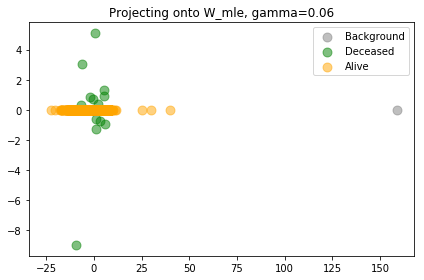

In [8]:
X = foreground_norm
Y = background_norm
X, Y = X.T, Y.T
gamma = 0.06
k = 2
#plt.figure(figsize=(len(gamma_range) * 7, 5))

pcpca = PCPCA(gamma=gamma, n_components=k)
X_proj, Y_proj = pcpca.fit_transform(X, Y)
plt.title("Projecting onto W_mle, gamma=" + str(gamma))
plt.scatter(Y[0, :], Y[1, :], alpha=0.5, label="Background", s=80, color="gray")
plt.scatter(X_proj[0, :13], X_proj[1, :13], alpha=0.5, label="Deceased", s=80, color="green")
plt.scatter(X_proj[0, 13:], X[1, 13:], alpha=0.5, label="Alive", s=80, color="orange")

origin = np.array([[0], [0]])  # origin point
# Doesn't work in > 2 dimensions
#abline(slope=pcpca.W_mle[1, 0] / pcpca.W_mle[0, 0], intercept=0)
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
np.argsort(pcpca.W_mle[:, 1])

array([22,  4,  8, 10, 23, 17, 14, 15, 18, 24,  6, 27, 16, 11,  2,  0, 12,
        3, 32,  1, 30, 28, 19, 29, 31, 13,  7, 33, 34, 25, 26,  9, 21, 20,
        5])

In [10]:
foreground_a.columns[np.argsort(-1* np.abs(pcpca.W_mle[:, 1]))]

Index(['UREA NITROGEN', 'BILIRUBIN', 'CALCIUM', 'CREATININE', 'POTASSIUM',
       'SODIUM', 'HEMOGLOBIN', 'HEMATOCRIT', 'URINE OUTPUT', 'PH',
       'METHEMOGLOBIN', 'PEEP', 'PARTIAL THROMBOPLASTIN TIME', 'FIO2',
       'Antiretrovirals', 'Influenza Agents', 'PLATELETS', 'CHLORIDE',
       'WHITE BLOOD CELLS', 'CARBOXYHEMOGLOBIN', 'OXYGEN (L)', 'PCO2',
       'LACTATE', 'INSPIRED OXYGEN', 'Mineralocorticoids',
       'Nonsteroidal Anti-inflammatory Agents (NSAIDs)', 'BASE EXCESS',
       'ALBUMIN', 'PO2', 'Respiratory Aids', 'Corticosteroids - Topical',
       'INTERNATIONAL NORMALIZED RATIO', 'BICARBONATE', 'ANION GAP',
       'Glucocorticosteroids'],
      dtype='object')

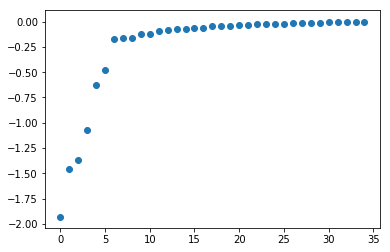

In [11]:
plt.scatter(np.arange(pcpca.W_mle.shape[0]), np.sort(-1* np.abs(pcpca.W_mle[:, 1])))

(array([6353.,    0.,    0.,   20.,   52.,   95.,  169.,  263.,  381.,
         412.,  508.,  509.,  570.,  525.,  513.,  575.,  498.,  532.,
         491.,  510.,  464.,  497.,  438.,  414.,  382.,  379.,  362.,
         369.,  309.,  311.,  270.,  342.,  309.,  328.,  316.,  273.,
         280.,  267.,  232.,  243.,  252.,  227.,  243.,  217.,  191.,
         188.,  194.,  186.,  163.,  178.,  141.,  167.,  144.,  134.,
         170.,  169.,  131.,  144.,  133.,  124.,  140.,  103.,  106.,
         112.,   97.,   91.,   82.,   92.,   91.,   74.,   81.,   69.,
          71.,   70.,   52.,   84.,   75.,   60.,   91.,   60.,   70.,
          59.,   68.,   61.,   46.,   54.,   50.,   43.,   63.,   54.,
          52.,   40.,   35.,   21.,   36.,   50.,   35.,   38.,   35.,
          72.]),
 array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.,
        12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.,
        25., 26., 27., 28., 29., 30., 31., 32., 33., 34.

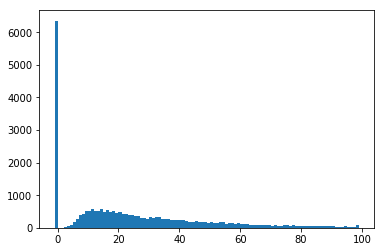

In [12]:
plt.hist(data[data['UREA NITROGEN']<100]['UREA NITROGEN'], bins=100)

## Strategy 3: Use the highest variance features

In [13]:
data.var(numeric_only=True)

Unnamed: 0                                        6.056130e+07
ALBUMIN                                           3.720515e+09
ANION GAP                                         0.000000e+00
BASE EXCESS                                       7.064244e+10
BICARBONATE                                       8.848582e-02
BILIRUBIN                                         1.411849e+11
CALCIUM                                           5.206193e+10
CARBOXYHEMOGLOBIN                                 3.554666e+12
CHLORIDE                                          6.321005e+10
CREATININE                                        6.138137e+11
HEMATOCRIT                                        1.189186e+11
HEMOGLOBIN                                        7.807254e+10
INSPIRED OXYGEN                                   3.069830e+01
INTERNATIONAL NORMALIZED RATIO                    8.178736e+10
LACTATE                                           1.819771e+11
METHEMOGLOBIN                                     5.312

In [14]:
highest_variance_columns = ['ALBUMIN', 
       'BASE EXCESS', 'BILIRUBIN', 'CALCIUM',
       'CARBOXYHEMOGLOBIN', 'CHLORIDE', 'CREATININE', 'HEMATOCRIT',
       'HEMOGLOBIN', 'INSPIRED OXYGEN', 'INTERNATIONAL NORMALIZED RATIO',
       'LACTATE', 'METHEMOGLOBIN', 'PARTIAL THROMBOPLASTIN TIME', 'PCO2', 'PH',
       'PLATELETS', 'PO2', 'POTASSIUM', 'SODIUM', 'UREA NITROGEN',
       'URINE OUTPUT', 'WHITE BLOOD CELLS', 'FIO2', 'PEEP', 'OXYGEN (L)']

In [15]:
background = data[data['Glucocorticosteroids'] == 0][highest_variance_columns]
foreground = data[data['Glucocorticosteroids'] == 1]
foreground_a = foreground[foreground['is_deceased_next_t'] == 1][highest_variance_columns]
foreground_b = foreground[foreground['is_deceased_next_t'] == 0][highest_variance_columns]

background_norm = normalize(background)
foreground_a_norm = normalize(foreground_a)
foreground_b_norm = normalize(foreground_b)
foreground_norm = np.concatenate([foreground_a_norm, foreground_b_norm], axis=0)
X = foreground_norm
Y = background_norm
X, Y = X.T, Y.T

In [16]:
run_pcpca(X, Y)

Gamma: 0 MSE: 0.9196063358146759
Gamma: 0.01 MSE: 0.910717282938624
Gamma: 0.05 MSE: 0.7543517544193997
Gamma: 0.06 MSE: 0.4517035582748376
Gamma: 0.07 MSE: 2.9998557675403736
Gamma: 0.08 MSE: 1.3547225278306905


<Figure size 3024x360 with 0 Axes>

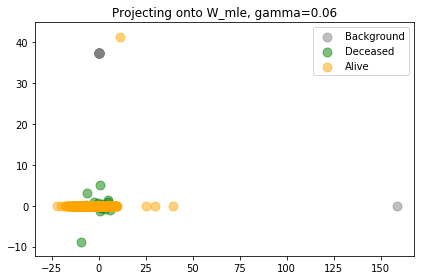

In [17]:
X = foreground_norm
Y = background_norm
X, Y = X.T, Y.T
gamma = 0.06
k = 2
#plt.figure(figsize=(len(gamma_range) * 7, 5))

pcpca = PCPCA(gamma=gamma, n_components=k)
X_proj, Y_proj = pcpca.fit_transform(X, Y)
plt.title("Projecting onto W_mle, gamma=" + str(gamma))
plt.scatter(Y[0, :], Y[1, :], alpha=0.5, label="Background", s=80, color="gray")
plt.scatter(X_proj[0, :13], X_proj[1, :13], alpha=0.5, label="Deceased", s=80, color="green")
plt.scatter(X_proj[0, 13:], X[1, 13:], alpha=0.5, label="Alive", s=80, color="orange")

origin = np.array([[0], [0]])  # origin point
# This is the line that distinguishes between the two classes.
#abline(slope=pcpca.W_mle[1, 0] / pcpca.W_mle[0, 0], intercept=0)
plt.legend()
plt.tight_layout()
plt.show()

## Strategy 4: Normalize without -1 and 99999 values, use missingness imputer

In [35]:
cleaned_data = data.replace(-1, 0)
cleaned_data = cleaned_data.replace(99999, 0)

In [37]:
columns = ['ALBUMIN', 'ANION GAP',
       'BASE EXCESS', 'BICARBONATE', 'BILIRUBIN', 'CALCIUM',
       'CARBOXYHEMOGLOBIN', 'CHLORIDE', 'CREATININE', 'HEMATOCRIT',
       'HEMOGLOBIN', 'INSPIRED OXYGEN', 'INTERNATIONAL NORMALIZED RATIO',
       'LACTATE', 'METHEMOGLOBIN', 'PARTIAL THROMBOPLASTIN TIME', 'PCO2', 'PH',
       'PLATELETS', 'PO2', 'POTASSIUM', 'SODIUM', 'UREA NITROGEN',
       'URINE OUTPUT', 'WHITE BLOOD CELLS', 'FIO2', 'PEEP', 'OXYGEN (L)',
       'Respiratory Aids', 'Nonsteroidal Anti-inflammatory Agents (NSAIDs)',
       'Corticosteroids - Topical', 'Mineralocorticoids',
       'Glucocorticosteroids', 'Influenza Agents', 'Antiretrovirals']


background = cleaned_data[cleaned_data['Glucocorticosteroids'] == 0][columns]
foreground = cleaned_data[cleaned_data['Glucocorticosteroids'] == 1]
foreground_a = foreground[foreground['is_deceased_next_t'] == 1][columns]
foreground_b = foreground[foreground['is_deceased_next_t'] == 0][columns]


print("Background shape: ", background.shape)
print("Foreground_a shape: ", foreground_a.shape)
print("Foreground_b shape: ", foreground_b.shape)
#print("Foreground shape: ", foreground.shape)

Background shape:  (25170, 35)
Foreground_a shape:  (13, 35)
Foreground_b shape:  (1695, 35)


In [40]:
background_norm = normalize(background)
foreground_a_norm = normalize(foreground_a)
foreground_b_norm = normalize(foreground_b)
foreground_norm = np.concatenate([foreground_a_norm, foreground_b_norm], axis=0)
X = foreground_norm
Y = background_norm
X, Y = X.T, Y.T

In [41]:
# How do we impute missing data?
gamma_range = [0, 0.01, 0.05, 0.06, 0.07, 0.08]
k = 1
plt.figure(figsize=(len(gamma_range) * 7, 5))
for ii, gamma in enumerate(gamma_range):
    pcpca = PCPCA(gamma=gamma, n_components=k)

    pcpca.fit(X, Y)
    print("Gamma: " + str(gamma) + " MSE: " + str(pcpca.sigma2_mle))


Gamma: 0 MSE: 0.8224826026819592
Gamma: 0.01 MSE: 0.805644667018271
Gamma: 0.05 MSE: 0.5339990329734213
Gamma: 0.06 MSE: 0.023041525694556263
Gamma: 0.07 MSE: 4.302017677268379
Gamma: 0.08 MSE: 1.5355050307191802


<Figure size 3024x360 with 0 Axes>

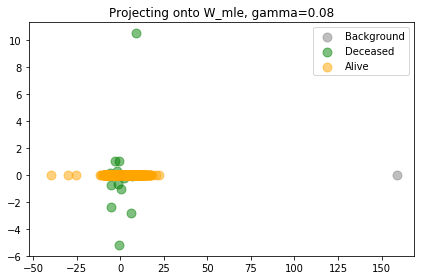

In [42]:
pcpca = PCPCA(gamma=0.06, n_components=2)
X_proj, Y_proj = pcpca.fit_transform(X, Y)
plt.title("Projecting onto W_mle, gamma=" + str(gamma))
plt.scatter(Y[0, :], Y[1, :], alpha=0.5, label="Background", s=80, color="gray")
plt.scatter(X_proj[0, :13], X_proj[1, :13], alpha=0.5, label="Deceased", s=80, color="green")
plt.scatter(X_proj[0, 13:], X[1, 13:], alpha=0.5, label="Alive", s=80, color="orange")

origin = np.array([[0], [0]])  # origin point
# This is the line that distinguishes between the two classes.
#abline(slope=pcpca.W_mle[1, 0] / pcpca.W_mle[0, 0], intercept=0)
plt.legend()
plt.tight_layout()
plt.show()

In [43]:
# Impute the missing values based on the original set?
nan_data = data.replace(-1, np.nan)
nan_data = nan_data.replace(99999, np.nan)
nan_data

,Unnamed: 0,pat_id,order_time,ALBUMIN,ANION GAP,BASE EXCESS,BICARBONATE,BILIRUBIN,CALCIUM,CARBOXYHEMOGLOBIN,...,PEEP,OXYGEN (L),Respiratory Aids,Nonsteroidal Anti-inflammatory Agents (NSAIDs),Corticosteroids - Topical,Mineralocorticoids,Glucocorticosteroids,Influenza Agents,Antiretrovirals,is_deceased_next_t
0,0,69036d47ac,2020-03-02 12:00:00,NaN,NaN,-21.5,NaN,0.2,8.8,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0
1,1,69036d47ac,2020-03-03 00:00:00,NaN,NaN,NaN,NaN,NaN,8.2,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0
2,2,69036d47ac,2020-03-03 12:00:00,NaN,NaN,NaN,NaN,NaN,8.0,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0
3,3,69036d47ac,2020-03-04 00:00:00,NaN,NaN,-5.1,NaN,NaN,8.0,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0
4,4,69036d47ac,2020-03-04 12:00:00,NaN,NaN,NaN,NaN,NaN,8.3,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0
5,5,69036d47ac,2020-03-15 00:00:00,NaN,NaN,-18.8,NaN,0.4,8.8,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0
6,6,69036d47ac,2020-03-15 12:00:00,NaN,NaN,-10.6,NaN,NaN,8.6,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0
7,7,69036d47ac,2020-03-16 00:00:00,NaN,NaN,NaN,NaN,NaN,8.5,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0
8,8,69036d47ac,2020-03-21 12:00:00,NaN,NaN,NaN,NaN,0.3,8.8,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0
9,9,69036d47ac,2020-03-22 00:00:00,NaN,NaN,NaN,NaN,0.3,8.5,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0


In [44]:
columns = ['ALBUMIN', 'ANION GAP',
       'BASE EXCESS', 'BICARBONATE', 'BILIRUBIN', 'CALCIUM',
       'CARBOXYHEMOGLOBIN', 'CHLORIDE', 'CREATININE', 'HEMATOCRIT',
       'HEMOGLOBIN', 'INSPIRED OXYGEN', 'INTERNATIONAL NORMALIZED RATIO',
       'LACTATE', 'METHEMOGLOBIN', 'PARTIAL THROMBOPLASTIN TIME', 'PCO2', 'PH',
       'PLATELETS', 'PO2', 'POTASSIUM', 'SODIUM', 'UREA NITROGEN',
       'URINE OUTPUT', 'WHITE BLOOD CELLS', 'FIO2', 'PEEP', 'OXYGEN (L)',
       'Respiratory Aids', 'Nonsteroidal Anti-inflammatory Agents (NSAIDs)',
       'Corticosteroids - Topical', 'Mineralocorticoids',
       'Glucocorticosteroids', 'Influenza Agents', 'Antiretrovirals']


background = nan_data[cleaned_data['Glucocorticosteroids'] == 0][columns]
foreground = nan_data[cleaned_data['Glucocorticosteroids'] == 1]
foreground_a = foreground[foreground['is_deceased_next_t'] == 1][columns]
foreground_b = foreground[foreground['is_deceased_next_t'] == 0][columns]


print("Background shape: ", background.shape)
print("Foreground_a shape: ", foreground_a.shape)
print("Foreground_b shape: ", foreground_b.shape)
#print("Foreground shape: ", foreground.shape)

Background shape:  (25170, 35)
Foreground_a shape:  (13, 35)
Foreground_b shape:  (1695, 35)


In [45]:
background_norm = normalize(background)
foreground_a_norm = normalize(foreground_a)
foreground_b_norm = normalize(foreground_b)
foreground_norm = np.concatenate([foreground_a_norm, foreground_b_norm], axis=0)
X = foreground_norm
Y = background_norm
# X, Y = X.T, Y.T

/Users/aishwaryamandyam/anaconda3/envs/gym/lib/python3.5/site-packages/sklearn/utils/extmath.py:776: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/aishwaryamandyam/anaconda3/envs/gym/lib/python3.5/site-packages/sklearn/utils/extmath.py:781: RuntimeWarning: Degrees of freedom <= 0 for slice.
  new_unnormalized_variance = np.nanvar(X, axis=0) * new_sample_count
/Users/aishwaryamandyam/anaconda3/envs/gym/lib/python3.5/site-packages/sklearn/utils/extmath.py:776: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/aishwaryamandyam/anaconda3/envs/gym/lib/python3.5/site-packages/sklearn/utils/extmath.py:781: RuntimeWarning: Degrees of freedom <= 0 for slice.
  new_unnormalized_variance = np.nanvar(X, axis=0) * new_sample_count
/Users/aishwaryamandyam/anaconda3/envs/gym/lib/python3.5/site-packages/sklearn/utils/extmath.py:776: RuntimeWarning: i

In [51]:
X = X.T
X = pcpca.impute_missing_data(X)

In [52]:
Y = Y.T
Y = pcpca.impute_missing_data(Y)

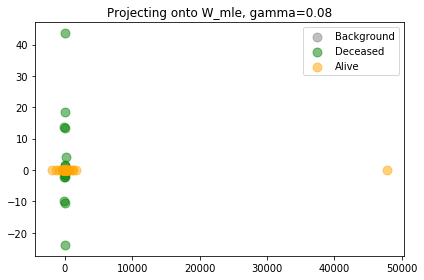

In [53]:
pcpca = PCPCA(gamma=0.06, n_components=2)
X_proj, Y_proj = pcpca.fit_transform(X, Y)
plt.title("Projecting onto W_mle, gamma=" + str(gamma))
plt.scatter(Y[0, :], Y[1, :], alpha=0.5, label="Background", s=80, color="gray")
plt.scatter(X_proj[0, :13], X_proj[1, :13], alpha=0.5, label="Deceased", s=80, color="green")
plt.scatter(X_proj[0, 13:], X[1, 13:], alpha=0.5, label="Alive", s=80, color="orange")

origin = np.array([[0], [0]])  # origin point
# This is the line that distinguishes between the two classes.
#abline(slope=pcpca.W_mle[1, 0] / pcpca.W_mle[0, 0], intercept=0)
plt.legend()
plt.tight_layout()
plt.show()